In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


# Set-up


In [2]:
import pandas as pd
import numpy as np

df = pd.read_pickle("saved/inst.dat")

In [3]:
# drop redundant cols

from functions.labels import *

label_dicts = {
    "tgt": tgt_labels,
    "fiw": fiw_labels,
    "ief": ief_labels,
    "efw": efw_labels,
    "pts": pts_labels,
    "p5d": p5d_labels,
    "wb_iq": wb_iq_labels,
    "wgi": wgi_labels,
    "controls": controls_labels,
}

keep_cols = ['country', 'year', 'iso_code_1','iso_code_2', 'region'] + [v for d in label_dicts.values() for v in d.keys()]
dropped = [c for c in df.columns if c not in keep_cols]
df = df[[c for c in df.columns if c in keep_cols]].copy()
print(f"Kept {len(df.columns)} cols, dropped {len(dropped)}")

Kept 136 cols, dropped 83


In [4]:
# create lagged target var, drop other target vars

def prep_target(df, lag=False):
    us_yields = df.loc[df['country'] == 'United States', ['year', 'tgt_yield']].set_index('year')['tgt_yield']
    df['tgt_spread'] = df['year'].map(us_yields)
    df['tgt_spread'] = df['tgt_yield'] - df['tgt_spread']
    df.insert(5, 'tgt_spread', df.pop('tgt_spread'))
    df = df.sort_values(['country', 'year'])
    df = df.drop(columns=['tgt_yield'])
    df = df[df.country!='United States'] # remove US as an observation
    if lag:
      df['tgt_spread_lag'] = df.groupby('country')['tgt_spread'].shift(-1)
      df.insert(5, 'tgt_spread_lag', df.pop('tgt_spread_lag'))
    return df

df = prep_target(df, lag=False)

In [5]:
# drop obs without target var

b_obs, b_cty = len(df), df["country"].nunique()
df = df.dropna(subset=["tgt_spread"]).copy().reset_index(drop=True)
a_obs, a_cty = len(df), df["country"].nunique()

print(f"Kept {a_cty} countries, dropped {b_cty - a_cty}\nKept {a_obs:,} obs, dropped {(b_obs - a_obs):,}")

df.head()

Kept 71 countries, dropped 127
Kept 2,193 obs, dropped 10,345


,country,year,iso_code_1,iso_code_2,region,tgt_spread,efw_economic_freedom_summary_index,efw_1a_government_consumption,efw_1b_transfers_and_subsidies,efw_1c_government_investment,...,wb_iq_sci_prdc,wb_iq_sci_srce,wb_iq_spi_ovrl,wb_iq_spi_pil1,wb_iq_spi_pil2,wb_iq_spi_pil3,wb_iq_spi_pil4,wb_iq_spi_pil5,wb_iq_wef_cust_xq,wb_iq_wef_port_xq
0,Angola,2013,AO,AGO,Middle Africa,5.845834,4.95,1.017647,8.253906,1.595059,...,83.333333,0.0,NaN,40.0,NaN,65.15000,NaN,NaN,118.8,156.6
1,Angola,2014,AO,AGO,Middle Africa,5.625834,4.86,3.297059,8.010978,2.142542,...,76.666667,10.0,NaN,20.0,NaN,66.41250,NaN,NaN,88.2,132.3
2,Angola,2015,AO,AGO,Middle Africa,5.634167,5.45,4.782353,8.886739,10.000000,...,73.333300,30.0,NaN,50.0,NaN,67.33125,NaN,NaN,NaN,NaN
3,Angola,2016,AO,AGO,Middle Africa,5.910000,5.18,5.923529,9.370572,10.000000,...,66.666500,30.0,43.735417,70.0,7.666667,70.44375,30.566667,40.0,NaN,NaN
4,Angola,2017,AO,AGO,Middle Africa,5.253333,4.60,6.341176,9.623978,6.326667,...,66.666500,40.0,46.689583,70.0,24.400000,70.88125,28.166667,40.0,NaN,NaN


Median year for 75% coverage: 2016


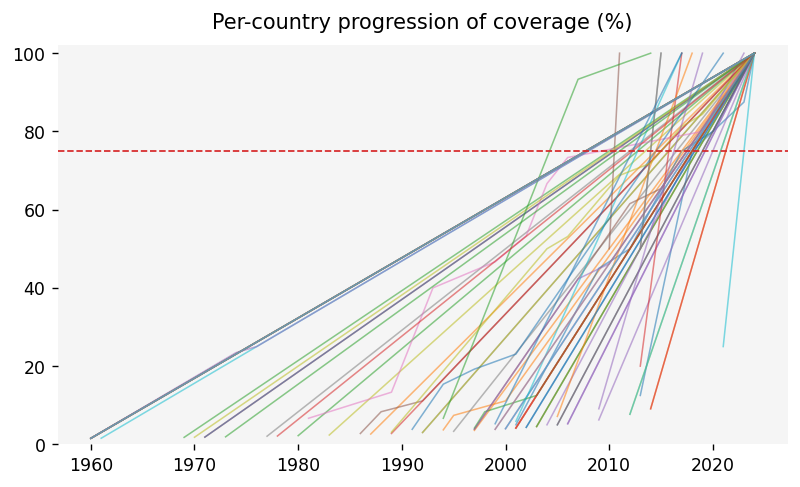

In [6]:
# identify split year as year when countries have c. 75% behind them

yname = "tgt_spread"

dff = df.dropna(subset=[yname]).sort_values(["country", "year"])
dff["cum_share"] = (dff.groupby("country").cumcount() + 1) / dff.groupby("country")["year"].transform("count")
cross_years = dff.loc[dff["cum_share"] >= 0.75].groupby("country")["year"].min()
print(f"Median year for 75% coverage: {int(cross_years.median())}")

from functions.plot import coverage_progression

coverage_progression(df)

In [7]:
# forward-fill

from functions.fill import fill

df_ff = fill(df)

# remove stale observations (fills from 3+ years)

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
ffilled_count = 0
removed_count = 0

for fcol in fcols:
    base = fcol[:-2]
    if base in df_ff.columns:
        m_ffilled = (df_ff[fcol] > 0) & (df_ff[fcol] <= 3) & df_ff[base].notna()
        m_removed = (df_ff[fcol] > 3) & df_ff[base].notna()
        ffilled_count += m_ffilled.sum()
        removed_count += m_removed.sum()
        df_ff.loc[df_ff[fcol] > 3, base] = np.nan

# fills summary

print(f"\n{removed_count:,} f-filled values removed due to staleness (3+ years), {ffilled_count:,} f-filled values remain")

from functions.fill import save_nulls_share

df_ff = save_nulls_share(df_ff, 'ffill')
print(f"Average observation null share decreased from {df_ff["nulls_init"].mean()*100:.0f} to {df_ff["nulls_ffill"].mean()*100:.0f} percent")
df_ff = df_ff.drop(columns=["nulls_init", "nulls_ffill"])

# save

df_ff.to_pickle("saved/df_f.dat")

F-filling Angola values
F-filling Armenia values
F-filling Australia values
F-filling Austria values
F-filling Bangladesh values
F-filling Belgium values
F-filling Botswana values
F-filling Brazil values
F-filling Bulgaria values
F-filling Canada values
F-filling Chile values
F-filling China values
F-filling Colombia values
F-filling Costa Rica values
F-filling Croatia values
F-filling Cyprus values
F-filling Czechia values
F-filling Côte d'Ivoire values
F-filling Denmark values
F-filling Estonia values
F-filling Fiji values
F-filling Finland values
F-filling France values
F-filling Germany values
F-filling Ghana values
F-filling Greece values
F-filling Hungary values
F-filling Iceland values
F-filling India values
F-filling Indonesia values
F-filling Ireland values
F-filling Israel values
F-filling Italy values
F-filling Japan values
F-filling Kyrgyzstan values
F-filling Latvia values
F-filling Lithuania values
F-filling Luxembourg values
F-filling Malaysia values
F-filling Malta valu

In [8]:
# load

df_ff = pd.read_pickle("saved/df_f.dat")

# drop _f metadata cols for further processing

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
df = df_ff.drop(columns=fcols)

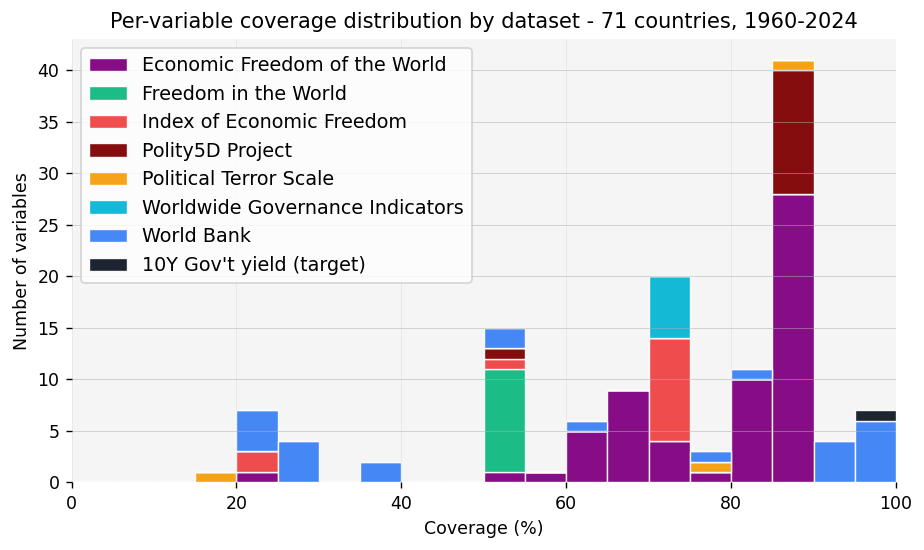

Removed 14 columns with less than 40% coverage, 267 remain
Removed ['efw_5diii_distorton_of_the_business_environment', 'ief_judicial_effectiveness', 'ief_fiscal_health', 'pts_pts_h', 'wb_iq_sci_mthd', 'wb_iq_sci_ovrl', 'wb_iq_sci_prdc', 'wb_iq_sci_srce', 'wb_iq_spi_ovrl', 'wb_iq_spi_pil2', 'wb_iq_spi_pil4', 'wb_iq_spi_pil5', 'wb_iq_wef_cust_xq', 'wb_iq_wef_port_xq']


In [9]:
# show columns coverage

from functions.plot import coverage_per_variable

coverage_per_variable(df)

# drop columns with less than 40% coverage

coverage = df.notna().mean()
to_drop = coverage[coverage < 0.4].index
df = df.drop(columns=to_drop)
print(f"Removed {len(to_drop)} columns with less than 40% coverage, {df_ff.shape[1]} remain")
print("Removed", to_drop.tolist() )

In [10]:
# create lagged variables for macro and IQ

def engineer_lag_vars(df, macro_vars, iq_vars, id_cols=["country", "year", "iso_code_1", "iso_code_2", "region"]):
    df = df.sort_values(id_cols).copy()
    n_before = df.shape[1]
    for var in macro_vars:
        df[f"{var}_delta"] = df.groupby("country")[var].diff(1)
        df[f"{var}_ma3"]   = df.groupby("country")[var].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
    for var in iq_vars:
        df[f"{var}_delta3"] = df.groupby("country")[var].diff(3)
    n_after = df.shape[1]
    print(f"Added {n_after - n_before} engineered columns")
    return df

id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread", "tgt_spread_lag"]
macro_vars = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_")]
iq_vars = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in id_cols))]

df = engineer_lag_vars(df, macro_vars, iq_vars)

# save dataset

df.to_pickle("saved/df.dat")

Added 129 engineered columns
